In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading in data
full_history = pd.read_csv('RawData/full_history.csv')

# Loads in added data with more features about the artist and track popularity
added_data = pd.concat([pd.read_csv('Cleaned_Data/2021_22RESULTS_REAL.csv'), 
                                   pd.read_csv('Cleaned_Data/2023RESULTS_REAL.csv'),
                                   pd.read_csv('Cleaned_Data/2024RESULTS_REAL.csv')])
added_data = added_data.drop(columns = ['Unnamed: 0', 'master_metadata_album_album_name', 'top_track_popularities', 'ms_played']).rename(columns = {'master_metadata_track_name':'track_name',
                                                                         'master_metadata_album_artist_name':'artist_name',
                                                                         'spotify_track_uri':'track_id',
                                                                         'artist_ids':'artist_id',
                                                                         'track_popularities':'track_popularity'})
added_data = added_data.drop_duplicates(subset = ['track_id'])

full_history = full_history[['spotify_track_uri', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'ms_played', 'duration_ms']].dropna(subset=['danceability']).rename(columns = {'master_metadata_track_name': 'track_name', 'master_metadata_album_artist_name': 'artist_name',
                                                                                             'spotify_track_uri': 'track_id'})

/var/folders/v_/7gz326qj5hv0nz696tx9yb1h0000gn/T/ipykernel_85306/1041120154.py:2: DtypeWarning: Columns (12,13,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  full_history = pd.read_csv('RawData/full_history.csv')


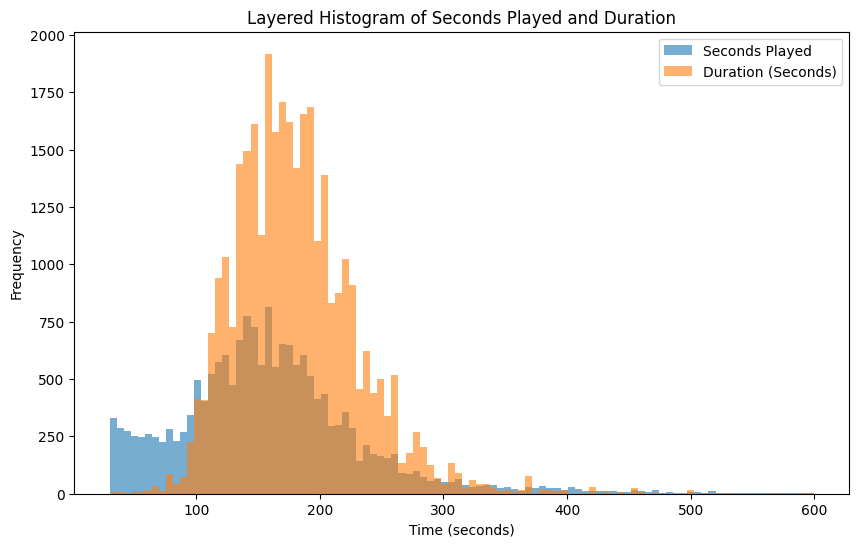

In [5]:
#  Merging full_history with added_data but only keeping the columns that are in full_history
full_history = full_history.merge(added_data, on = 'track_id', how = 'left')

# Remove rows with NA values in the relevant features in full_history, subset for only the relevant columns
full_history = full_history.dropna(subset=['danceability', 'duration_ms'])

# Make a column in full_history for seconds played
full_history['seconds_played'] = full_history['ms_played']/1000
full_history['duration_seconds'] = full_history['duration_ms']/1000

# Plotting the layered histogram
plt.figure(figsize=(10, 6))

# Histogram for 'seconds_played'
plt.hist(full_history['seconds_played'], bins=100, alpha=0.6, label='Seconds Played', range = (30, 600))

# Histogram for 'duration_seconds'
plt.hist(full_history['duration_seconds'], bins=100, alpha=0.6, label='Duration (Seconds)', range = (30, 600))

# Adding labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Layered Histogram of Seconds Played and Duration')
plt.legend()

# Show the plot
plt.show();

Spotify only counts a stream as a song played for at least 30 seconds, so I naturally set the lower bound there for seconds played. The distributions for the amount of time played as well as the duration of a song naturally taper off at about 350 seconds (5 minutes & 50 seconds), so I set that as the maximum.

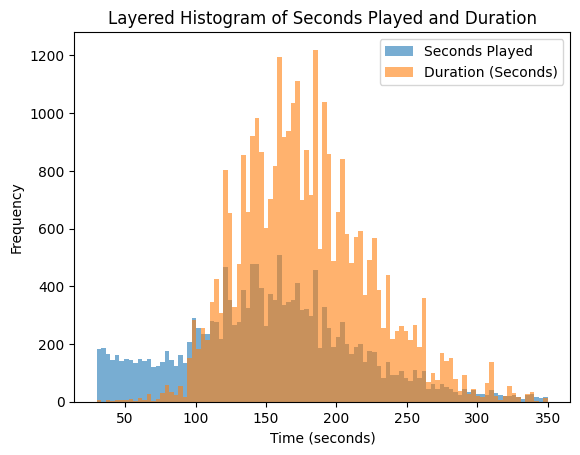

In [6]:
# Histogram for 'seconds_played'
plt.hist(full_history['seconds_played'], bins=100, alpha=0.6, label='Seconds Played', range = (30, 350))

# Histogram for 'duration_seconds'
plt.hist(full_history['duration_seconds'], bins=100, alpha=0.6, label='Duration (Seconds)', range = (30, 350))

# Adding labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Layered Histogram of Seconds Played and Duration')
plt.legend()

# Show the plot
plt.show()

In [7]:
listen = full_history[(full_history['seconds_played'] >= 30) & (full_history['seconds_played'] <= 350)]
avg_play = listen.groupby('track_id', as_index=False).agg({
    'seconds_played': 'mean',
}).rename(columns={'seconds_played': 'average_seconds_played'})

avg_play = avg_play.merge(listen.drop_duplicates(subset=['track_id']), on='track_id', how='left').sort_values('average_seconds_played', ascending=False).drop(columns=['seconds_played'])
avg_play['avg_completion_rate'] = avg_play['average_seconds_played'] / avg_play['duration_seconds']
avg_play = avg_play.drop(columns=['ms_played', 'duration_ms', 'duration_seconds'])
avg_play['total_plays'] = listen.groupby('track_id', as_index=False).agg({
    'seconds_played': 'count',
}).rename(columns={'seconds_played': 'total_plays'})['total_plays']
avg_play.to_csv("Cleaned_Data/Full_Data_With_Plays.csv")